# Softmax

The softmax strategy samples an action from a probability distribution over the action-value function, such that the probability of selecting an action is proportional to its current action-value estimate. The difference between Q-value estimates will create a tendency to select actions with the highest estimates more often, and actions with the lowest estimates less frequently.

In [10]:
import numpy as np

class BanditEnv:
    def __init__(self):
        """10-armed testbed"""
        self.size = 10                                        # 10 arms
        self.means = np.random.randn(self.size)
        
    def step(self, action):
        return np.random.normal(loc=self.means[action])
    
env = BanditEnv()

In [11]:
def decay_epsilon_greedy(env, init_epsilon=1.0, 
                         min_epsilon=0.01, decay_ratio=0.05, 
                         n_episodes=1000):
    Q = np.zeros((env.size), dtype=np.float64)
    N = np.zeros((env.size), dtype=int)
    Qe = np.empty((n_episodes, env.size), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    decay_episodes = int(n_episodes * decay_ratio)
    rem_episodes = n_episodes - decay_episodes
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0, decay_episodes)
    epsilons *= init_epsilon - min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_episodes), 'edge')
    for e in range(n_episodes):
        if np.random.uniform() > epsilons[e]:
            action = np.argmax(Q)
        else:
            action = np.random.randint(len(Q))
        reward = env.step(action)    
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        Qe[e] = Q
        returns[e] = reward
    return returns, Qe

In [12]:
def softmax(env, init_temp=1000, min_temp=0.1,
            decay_ratio=0.04,n_episodes=1000):
    
    Q = np.zeros((env.size), dtype=np.float64)
    N = np.zeros((env.size), dtype=int)

    Qe = np.empty((n_episodes, env.size), dtype=np.float64)
    returns = np.empty(n_episodes, dtype=np.float64)
    
    for e in range(n_episodes):
        
        # calculate the linearly decaying temperature 
        decay_episodes = n_episodes * decay_ratio
        temp = 1 - e / decay_episodes
        temp *= init_temp - min_temp
        temp += min_temp
        temp = np.clip(temp, min_temp, init_temp)

        # calculate the probabilities by applying the softmax function 
        # to the Q-values
        scaled_Q = Q / temp
        norm_Q = scaled_Q - np.max(scaled_Q)
        exp_Q = np.exp(norm_Q)
        probs = exp_Q / np.sum(exp_Q)
    
        # select the action based on probabilites
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]

        reward = env.step(action)
        
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qe[e] = Q
        returns[e] = reward
    
    return returns, Qe

In [13]:
from tqdm import tqdm

returns_epsilon_decay = []
returns_softmax = []

for i in tqdm(range(2000), desc='Running epsilon decay'):
    returns, _ = decay_epsilon_greedy(env=env) 
    returns_epsilon_decay.append(returns); 
    
for i in tqdm(range(2000), desc='Running softmax method'):
    returns, _ = softmax(env=env)
    returns_softmax.append(returns); 

returns_epsilon_decay = np.array(returns_epsilon_decay)
returns_softmax = np.array(returns_softmax)

Running optmistic method: 100%|█████████████| 2000/2000 [02:18<00:00, 14.43it/s]


In [14]:
# Average reward
avg_reward_epsilon_decay = np.average(returns_epsilon_decay, axis=0)
avg_reward_softmax = np.average(returns_softmax, axis=0)

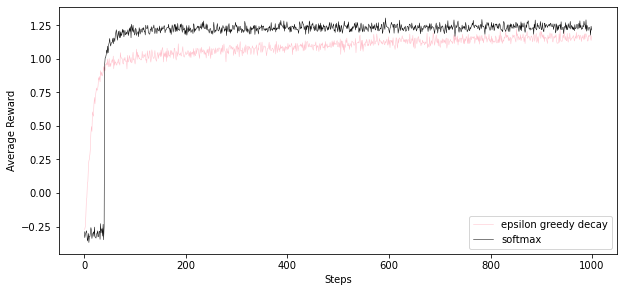

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

plt.subplot(2, 1, 1)
plt.plot(avg_reward_epsilon_decay, linewidth=0.5, color='pink',   label='epsilon greedy decay')
plt.plot(avg_reward_softmax, linewidth=0.5, color='black',   label='softmax')
plt.xlabel('Steps');
plt.ylabel('Average Reward')
plt.legend()

plt.show()